In [78]:
!pip install unidecode
!pip install pyspark

In [79]:
#Import the necessary libraries
import unidecode
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, array, count, expr

UPLOAD DATASET FROM KAGGLE TO GOOGLE DRIVE

In [81]:
#Upload google drive to access the file
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
#Get the file path and upload it in a dataframe
file_path = "/content/drive/MyDrive/Dataset/epi_r.csv"

df = pd.read_csv(file_path)

#Print the head of the dataframe
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
'''
Alternative method:
from google.colab import files
uploaded = files.upload()

# Load into a DataFrame
df = pd.read_csv("epi_r.csv")
df.head()'''


'\nAlternative method:\nfrom google.colab import files\nuploaded = files.upload()  \n\n# Load into a DataFrame\ndf = pd.read_csv("epi_r.csv")  \ndf.head()'

DATA CLEANING

In [84]:
#Doing preliminary analysis on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


In [85]:
df.describe()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.000299,0.000050,0.000848,0.001346,0.000349,...,0.001247,0.026332,0.000050,0.000299,0.014861,0.000150,0.000349,0.001396,0.000948,0.022741
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.017296,0.007062,0.029105,0.036671,0.018681,...,0.035288,0.160123,0.007062,0.017296,0.121001,0.012231,0.018681,0.037343,0.030768,0.149080
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
df.dtypes

,0
title,object
rating,float64
calories,float64
protein,float64
fat,float64
...,...
cookbooks,float64
leftovers,float64
snack,float64
snack week,float64


In [87]:
#Missing values analysis
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Create a summary DataFrame for easier visualization
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print(missing_summary)

#Based on the summary, drop the rows with NaN values
df = df.dropna()
#Check the updated version
df.info()

            Missing Values  Percentage
title                    0    0.000000
rating                   0    0.000000
calories              4117   20.531618
protein               4162   20.756034
fat                   4183   20.860762
...                    ...         ...
cookbooks                0    0.000000
leftovers                0    0.000000
snack                    0    0.000000
snack week               0    0.000000
turkey                   0    0.000000

[680 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 15864 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 82.4+ MB


In [88]:
#Check for any duplicated rows
# Find duplicated rows
duplicated_rows = df[df.duplicated(keep=False)]

# Display duplicated rows
print("Duplicated Rows:")
print(duplicated_rows)

'''Based on the dataset, I will not remove the duplicate rows as the
title is unique and it will be helpful to identify the recipes'''


Duplicated Rows:
                                                   title  rating  calories  \
14                                        Peach Mustard    3.125     134.0   
17                          Crisp Braised Pork Shoulder    4.375     890.0   
24                              Sea Salt-Roasted Pecans    3.750     279.0   
25                               Garlic Baguette Crumbs    0.000      95.0   
27                                    Dried Pear Crisps    2.500      14.0   
...                                                  ...     ...       ...   
20027  Grilled Fillet of Beef with Tomato Ginger Vina...   4.375     738.0   
20032                                 4-3-2-1 Spice Rub    4.375      16.0   
20039                                 Cauliflower Purée    3.125     364.0   
20041                 Chicken with White Wine and Herbs    2.500     843.0   
20045                                 Blueberry Compote    3.750     182.0   

       protein   fat  sodium  #cakeweek  #wast

'Based on the dataset, I will not remove the duplicate rows as the\ntitle is unique and it will be helpful to identify the recipes'

In [89]:
# Rename columns by removing the '#' character
df.rename(columns=lambda x: x.lstrip('#'), inplace=True)

In [90]:
# Normalize column names by removing accents and special characters
df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
df.columns = [unidecode.unidecode(col) for col in df.columns]  # Remove accents
df.columns = df.columns.str.replace(r'[,._/&+\-\']', '', regex=True)

In [91]:
#Removing unnecessary columns
'''Since this dataset contains 680 columns, I will reduce it by
removing the columns where all the row values are equal to 0 '''

df = df.loc[:, (df != 0).any(axis=0)]
print("Remaining columns:\n", df.columns)


Remaining columns:
 Index(['title', 'rating', 'calories', 'protein', 'fat', 'sodium', 'cakeweek',
       'wasteless', '22minutemeals', '3ingredientrecipes',
       ...
       'yellowsquash', 'yogurt', 'yonkers', 'yuca', 'zucchini', 'cookbooks',
       'leftovers', 'snack', 'snackweek', 'turkey'],
      dtype='object', length=668)


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


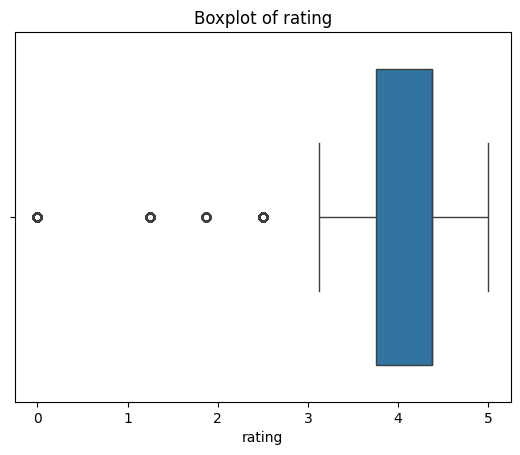

<class 'pandas.core.frame.DataFrame'>
Index: 13959 entries, 1 to 20051
Columns: 668 entries, title to turkey
dtypes: float64(667), object(1)
memory usage: 71.2+ MB


In [92]:
#Detecting outliers in the rating column and removing them using boxplot and IQR
sns.boxplot(x=df['rating'])
plt.title("Boxplot of rating")
plt.show()

q1 = df['rating'].quantile(0.25)
q3 = df['rating'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Keep only values within IQR bounds
df = df[(df['rating'] >= lower_bound) & (df['rating'] <= upper_bound)]

df.shape
df.info()


EXPLORATORY DATA ANALYSIS

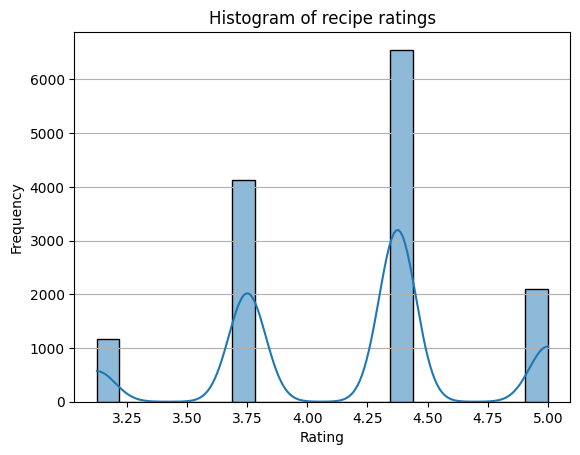

In [93]:
#Histogram of recipe ratings: Distribution of recipes
sns.histplot(df['rating'], bins=20, kde=True)
plt.title("Histogram of recipe ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

In [94]:
'''Since the data set is large, I am going to use PySpark for analysis along
  with Python'''
spark = SparkSession.builder \
    .master("local") \
    .appName("RecipeDataAnalysis") \
    .getOrCreate()


In [95]:
#Creating a seperate dataframe to use in spark
spark_df = spark.createDataFrame(df)

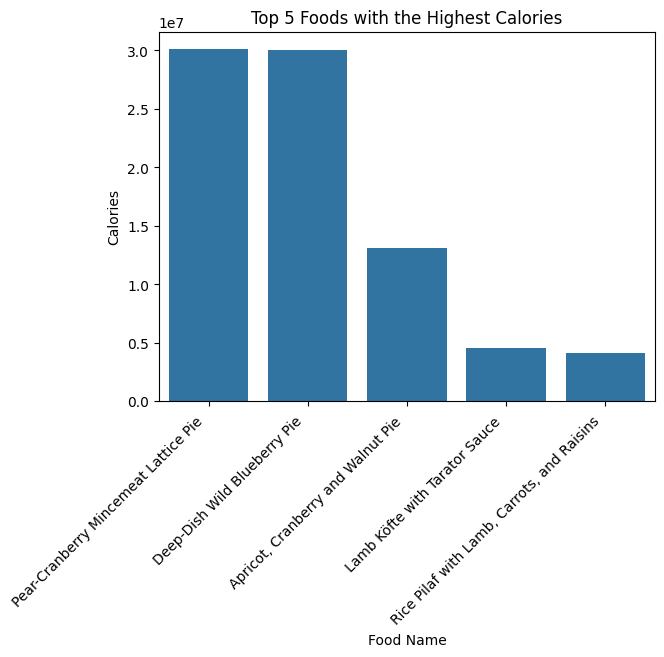

In [96]:
#Extract the top 5 foods with the highest calories
highest_calorie_df = spark_df.orderBy(spark_df["calories"].desc()).select("title", "calories").limit(5)

#Convert the Spark DataFrame to Pandas DataFrame for visualization
highest_calorie_pd = highest_calorie_df.toPandas()

#Create a bar plot using Seaborn
sns.barplot(x="title", y="calories", data=highest_calorie_pd)
plt.title("Top 5 Foods with the Highest Calories")
plt.xlabel("Food Name")
plt.ylabel("Calories")
plt.xticks(rotation=45, ha='right')
plt.show()

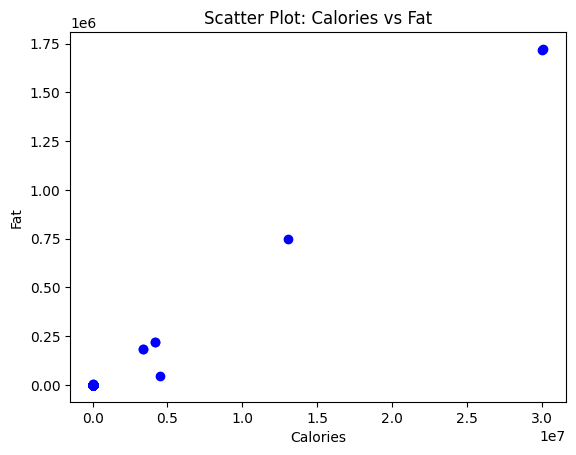

In [97]:
#Scatter plot to show the relationship between calories and fat
calorie_fat_df = spark_df.select("calories", "fat").toPandas()

# Scatter Plot for Calories vs. Fat
plt.scatter(calorie_fat_df["calories"], calorie_fat_df["fat"], color='blue')
plt.title("Scatter Plot: Calories vs Fat")
plt.xlabel("Calories")
plt.ylabel("Fat")
plt.show()


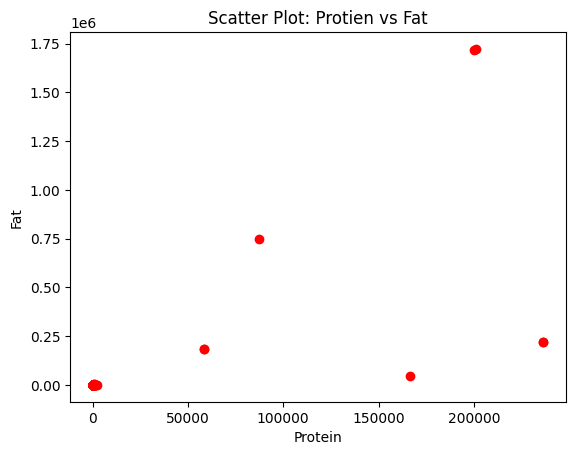

In [103]:
#Scatter plot to show the relationship between protein and fat
calorie_fat_df = spark_df.select("protein", "fat").toPandas()

# Scatter Plot for Calories vs. Fat
plt.scatter(calorie_fat_df["protein"], calorie_fat_df["fat"], color='red')
plt.title("Scatter Plot: Protien vs Fat")
plt.xlabel("Protein")
plt.ylabel("Fat")
plt.show()


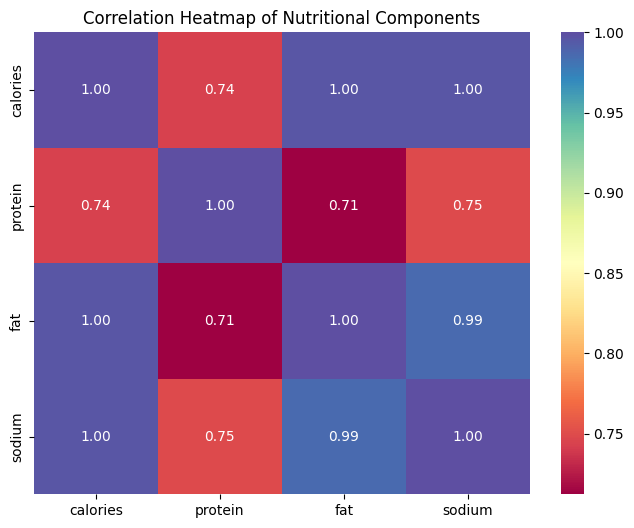

In [99]:
'''Using heatmap to visualize the correlation between calories, protein, fat, and sodium.'''

correlation_matrix = df[['calories', 'protein', 'fat', 'sodium']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', fmt=".2f")
plt.title("Correlation Heatmap of Nutritional Components")
plt.show()


<ipython-input-100-932f38874a3b>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diet_counts = df.groupby(['calorie_bins', 'vegan']).size().unstack(fill_value=0)


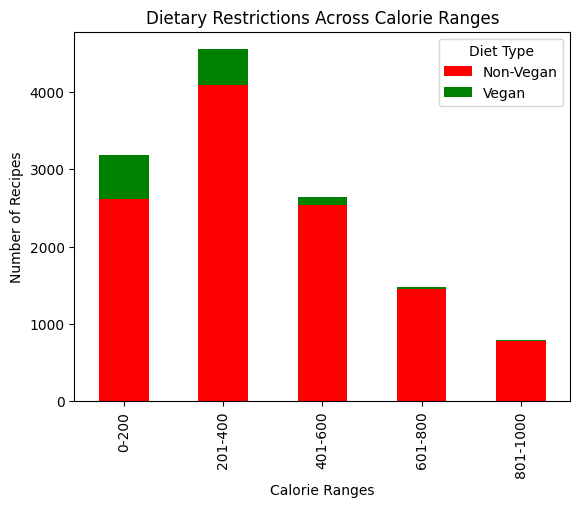

'Insight gained: Vegan recipes have lesser calories as compared\n  to non-vegan recipes. '

In [100]:
'''Creating a stacked bar plot To show the proportion of different recipe types
  (e.g., vegan, vegetarian) across various calorie ranges.'''
bins = [0, 200, 400, 600, 800, 1000]
labels = ['0-200', '201-400', '401-600', '601-800', '801-1000']
df['calorie_bins'] = pd.cut(df['calories'], bins=bins, labels=labels)

# Count the occurrences of each vegan/non-vegan in each calorie bin
diet_counts = df.groupby(['calorie_bins', 'vegan']).size().unstack(fill_value=0)

diet_counts.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title("Dietary Restrictions Across Calorie Ranges")
plt.xlabel("Calorie Ranges")
plt.ylabel("Number of Recipes")
plt.legend(title='Diet Type', labels=['Non-Vegan', 'Vegan'])
plt.show()


'''Insight gained: Vegan recipes have lesser calories as compared
  to non-vegan recipes. '''

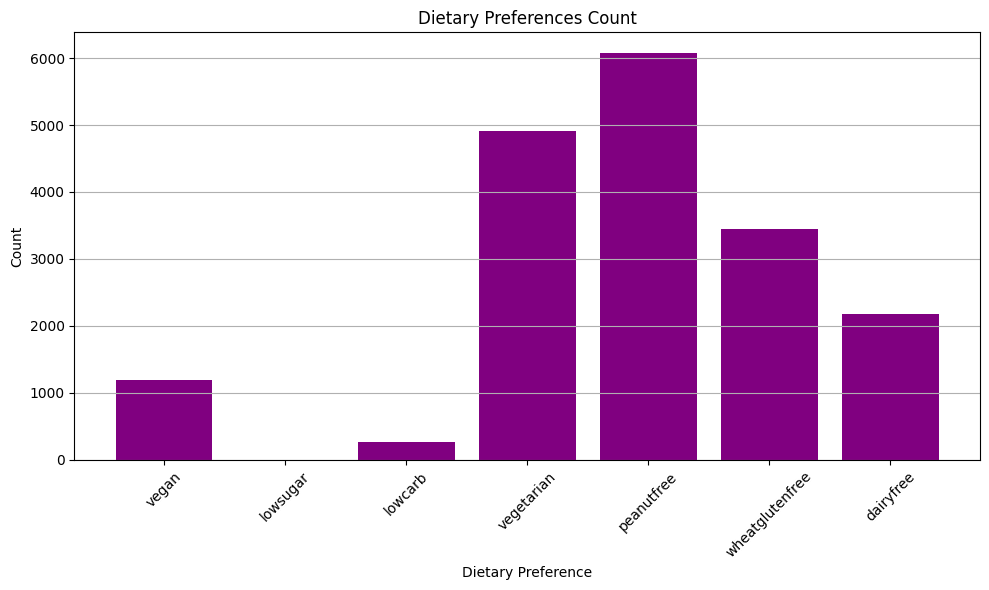

' Insight gain: Peanut-free recipes are gaining popularity as compared\n  to other dietary restrictions. Low-sugar recipes are the least'

In [101]:
'''Plotting a graph to depict the count of recipes with relation to dietary restrictions '''
# Create a list of dietary preference columns
dietary_columns = ["vegan", "vegetarian", "wheatglutenfree", "lowcarb", "dairyfree", "lowsugar", "peanutfree"]

# Transform the DataFrame to long format using selectExpr
melted_df = spark_df.selectExpr("stack({0}, {1}) as (dietary_preference, is_preferred)".format(
    len(dietary_columns),
    ', '.join(["'{0}', `{0}`".format(col_name) for col_name in dietary_columns])
))

# Filter to keep only the preferred dietary preferences
count_df = melted_df.filter(col("is_preferred") == '1') \
    .groupBy("dietary_preference") \
    .agg(count("*").alias("count"))

# Collect the results into a Pandas DataFrame
pandas_df = count_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['dietary_preference'], pandas_df['count'], color='purple')
plt.title('Dietary Preferences Count')
plt.xlabel('Dietary Preference')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

''' Insight gain: Peanut-free recipes are gaining popularity as compared
  to other dietary restrictions. Low-sugar recipes are the least'''

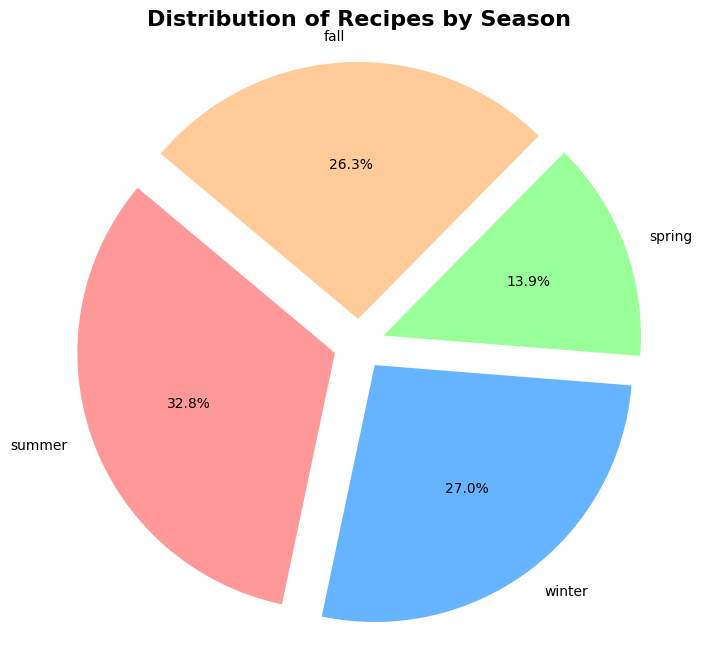

'Insight gained: The majority of recipes are made for summer, with \n  fall and winter coming a close second. The least recipes are in spring '

In [102]:
'''Plotting a pie chart to depict the relationship between seasons and number of recipes '''
from pyspark.sql.functions import col, sum as spark_sum
# Define season columns
season_columns = ["summer", "winter", "spring", "fall"]  # Adjust the list based on your DataFrame

# Create a new DataFrame to sum up the number of recipes in each season
season_counts = spark_df.select([spark_sum(col(season)).alias(season) for season in season_columns]).collect()[0]

# Prepare data for plotting
season_labels = season_columns
season_sizes = [season_counts[season] for season in season_columns]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(season_sizes,
        labels=season_labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'],  # Custom colors
        explode=[0.1] * len(season_sizes))

plt.title('Distribution of Recipes by Season', fontsize=16, fontweight='bold')
plt.axis('equal')

plt.show()

'''Insight gained: The majority of recipes are made for summer, with
  fall and winter coming a close second. The least recipes are in spring '''
